In [10]:
# This block imports modules, randomly separates the data into training / validation / test sets, 
# and defines and evaluates the pretrained model

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.version
from torchvision.models import resnet34
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid

# This implementation includes a scipy library to directly read .WAV files and uses TorchAudio for structure and transforms


import os
from scipy.io import wavfile
import torchaudio
import torchaudio.transforms as transforms
import soundfile
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device to GPU if available
#print(torch.version.cuda)
#print(device)

class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the audio files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # Walk through directory and collect file paths and labels
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for file_name in os.listdir(label_path):
                    if file_name.endswith(".wav"):
                        self.file_paths.append(os.path.join(label_path, file_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the audio file
        audio_path = self.file_paths[idx]
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono if it's stereo
        if waveform.size(0) > 1:  # Check if stereo
            waveform = waveform.mean(dim=0, keepdim=True)  # Average channels

        # Get the label
        label = self.labels[idx]
        
        # Apply transformation if specified
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform.squeeze(0), label

class AudioDataset_WithPadding(Dataset):
    def __init__(self, root_dir, max_length, transform=None):
        """
        Args:
            root_dir (str): Directory with all the audio files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.file_paths = []
        self.labels = []
        self.max_length = max_length
        self.transform = transform

        # Walk through directory and collect file paths and labels
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for file_name in os.listdir(label_path):
                    if file_name.endswith(".wav"):
                        self.file_paths.append(os.path.join(label_path, file_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the audio file
        audio_path = self.file_paths[idx]
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono if it's stereo
        if waveform.size(0) > 1:  # Check if stereo
            waveform = waveform.mean(dim=0, keepdim=True)  # Average channels

        # Pad waveform to the fixed length
        if waveform.size(1) < self.max_length:
            pad_amount = self.max_length - waveform.size(1)
            #print(pad_amount)
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount), "constant", 0)
        
        # Get the label
        label = self.labels[idx]
        if label == "Major":
            label_num = 0
        else:
            label_num = 1
        
        # Apply transformation if specified
        if self.transform:
            waveform = self.transform(waveform)
            #print(waveform.size(2))

        return waveform, label, label_num


transform = transforms.MelSpectrogram(sample_rate=16000, n_mels=64)

root_dir = "data/"

dataset_temp = AudioDataset(root_dir) # Create dataset from major / minor chords folders (chords are organized in folders by chord type)

waveforms = [dataset_temp[i][0] for i in range(len(dataset_temp))]

max_length = 0
for i, waveform in enumerate(waveforms):
    if (int(waveform.shape[0])) > max_length:
        max_length = int(waveform.shape[0])

dataset = AudioDataset_WithPadding(root_dir, max_length=max_length, transform=transform) # Create dataset from major / minor chords folders (chords are organized in folders by chord type)

waveforms = [dataset[i][0] for i in range(len(dataset))]

data_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle=True) # Load Dataset

for batch in data_loader:
    waveforms, labels, labels_num = batch

num_data = len(dataset) # Total Number of Data Points in Dataset

train_size = int(0.7*num_data) # Allocate 70% of Data Points for Training
val_size = int(0.15*num_data) # Allocate 15% of Data Points for Validation Set
test_size = num_data - train_size - val_size # Allocate Remaining Data Points (15%) for Test Set

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # Use random_split to randomly separate the dataset into training, validation, testing sets

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True) # training data loader with randomization and batch size 10
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False) # validation data loader with no randomization and batch size 10
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False) # test data loader with no randomization and batch size 10

num_class = 2
model_pretrained = resnet34(pretrained=True)
model_pretrained.fc = nn.Sequential(
    nn.Dropout(0.5), # implement dropout rate of 50% to discourage overfitting
    nn.Linear(model_pretrained.fc.in_features, num_class)
)

model_pretrained.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

num_major = 0
num_minor = 0

# Get count of major / minor chords in training set

for waveform, label, label_num in train_dataset:
    if label_num == 0:
        num_major += 1
    else:
        num_minor += 1

class_ns = torch.tensor([num_major, num_minor])
weights = 1.0 / class_ns
weights = weights / weights.sum()

criter = nn.CrossEntropyLoss(weight=weights)

model_pretrained.to(device) # move pretrained model to GPU

def visualize_hook(module, input, output):
    activation = output.squeeze(0) # find activations of layer, remove zeroes
    activation = activation.unsqueeze(1) # remove ones from activation tensor to match image characteristics

    grid = make_grid(activation, nrow=8, normalize=True, scale_each = True) # create grid using make_grid from activations
    
    plt.figure(figsize=(15, 15))
    for i in range(output.size(1)):
        #plt.subplot(8, 8, i + 1)
        plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap="gray") # show image with grid in grayscale
        #plt.imshow(output[0,i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()
# Choose a specific layer and register the hook
#layer_to_visualize = model_pretrained.conv1 # show convolutional layer 1
#hook = layer_to_visualize.register_forward_hook(visualize_hook)

#index = torch.randint(0,test_size-1,(1,)) # generate random index in range of test data set
#print(index)
#image, label = test_dataset[index] # image, label of selected random test image
#image = image.resize(3,224,224)
#image = image.unsqueeze(0).to(device) # move image to GPU


model_pretrained.eval()

#_ = model_pretrained(image)
#hook.remove() # Remove the hook



outputs_list = []
correct = 0
total = 0
loss_pretrained = 0
with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        #images, labels = images.to(device), labels.to(device)
        #print(images.shape)
        outputs = model_pretrained(waveforms)
        _, predicted = torch.max(outputs, 1)
        total+= len(labels)
        #batch_labels = []
        for i in range(len(labels_num)):
            if labels_num[i] == predicted[i]:
                correct+=1
        #print(batch_labels)
        #correct+= (predicted == batch_labels).sum().item()
        outputs_list.append(outputs)
        #batch_labels = torch.tensor(batch_labels)
        #print(batch_labels)
        loss = criter(outputs,labels_num)
        loss_pretrained += loss.item() * waveforms.size(0)
        

print("{}% Test Accuracy With Pre-Trained Model".format(correct/total*100))
print("Test Set Loss of {} With Pre-Trained Model".format(loss_pretrained))




C:\Users\sk3ll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sk3ll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


60.76923076923077% Test Accuracy With Pre-Trained Model
Test Set Loss of 375.62517642974854 With Pre-Trained Model


Training Model with Fully Connected (Output) Layer Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.8102282857438688
Training Accuracy After Epoch 1: 52.08%

Validation Loss For Epoch 1: 0.900309182703495
Validation Accuracy After Epoch 1: 45.31%

Epoch 2/10:

Training Loss For Epoch 2: 0.812696646186159
Training Accuracy After Epoch 2: 48.09%

Validation Loss For Epoch 2: 0.8432098040357232
Validation Accuracy After Epoch 2: 45.31%

Epoch 3/10:

Training Loss For Epoch 3: 0.7680877723828726
Training Accuracy After Epoch 3: 53.58%

Validation Loss For Epoch 3: 0.8134709484875202
Validation Accuracy After Epoch 3: 49.22%

Epoch 4/10:

Training Loss For Epoch 4: 0.7901459670503207
Training Accuracy After Epoch 4: 51.41%

Validation Loss For Epoch 4: 0.7742358790710568
Validation Accuracy After Epoch 4: 50.78%

Epoch 5/10:

Training Loss For Epoch 5: 0.7965927630811682
Training Accuracy After Epoch 5: 52.41%

Validation Loss For Epoch 5: 0.7651886846870184
Validation Accuracy After Ep

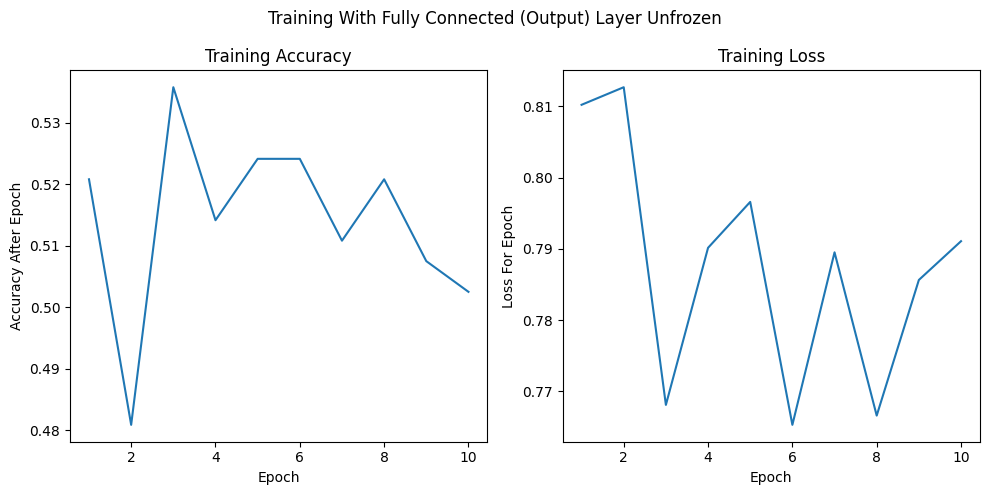

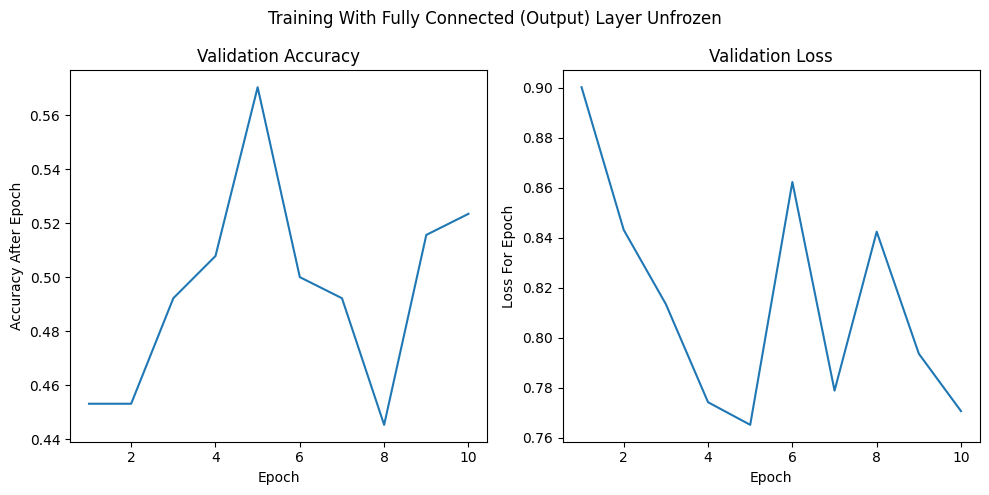

In [11]:
# This block fine-tunes the fully connected output layer of the model, beginning with the pretrained ResNet-34 model

import torch.optim as optim

model = resnet34(pretrained=True) # pre-trained ResNet-34 model
model.fc = nn.Sequential(
    nn.Dropout(0.5), # implement dropout rate of 50% to discourage overfitting
    nn.Linear(model.fc.in_features, num_class)
) # change fully connected output layer to 3 outputs to match class count
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

model = model.to(device) # move model to GPU

for param in model.parameters(): # freeze all model parameters
    param.requires_grad = False
for param in model.fc.parameters(): # unfreeze fully connected layer
    param.requires_grad = True

criter = nn.CrossEntropyLoss(weight=weights) # Cross-Entropy Loss Function
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4) # Adam optimizer with learning rate 1e-4 to start training

num_epoch = 10 # 10 epochs

def train_model(model, dataloader, criter, optimizer, num_epoch = 5):

    train_acc = [] # list of training accuracies during this training
    train_losses = [] # list of training losses during this training
    val_acc = [] # list of validation accuracies during this training 
    val_losses = [] # list of validation losses during this training
    
    for epoch in range(num_epoch):
        print("Epoch {}/{}:\n".format(epoch+1,num_epoch)) 

        model.train() # set model to training mode
        train_loss = 0 # training loss running total starts at zero
        train_correct = 0 # correctly classified images from training set running total starts at zero
        val_loss = 0 # validation loss running total starts at zero
        val_correct = 0 # correctly classified images from validation set running total starts at zero

        for inputs, labels, labels_num in dataloader["train"]:
            inputs, labels_num = inputs.to(device), labels_num.to(device) # move inputs (images) and labels to GPU

            optimizer.zero_grad()
            outputs = model(inputs) # feed forward
            _, class_preds_train = torch.max(outputs,1) # predict classes based on model output
            loss = criter(outputs,labels_num) # generate loss values

            loss.backward() # backpropagate
            optimizer.step()

            train_loss += loss.item() * inputs.size(0) # add loss from this epoch to training loss
            train_correct += torch.sum(class_preds_train == labels_num.data) # add correctly classified images count to total correctly classified for training set

        train_loss_epoch = train_loss / len(dataloader["train"].dataset) # training loss this epoch
        train_losses.append(train_loss_epoch) # add training loss this epoch to list of training losses
        train_acc_epoch = train_correct / len(dataloader["train"].dataset) # training accuracy this epoch
        train_acc.append(train_acc_epoch) # add training accuracy this epoch to list of training accuracies

        for inputs, labels, labels_num in dataloader["val"]: # performs same loss / accuracy calculations as training set for validation set
            inputs, labels_num = inputs.to(device), labels_num.to(device) 
            
            outputs = model(inputs)
            _, class_preds_val = torch.max(outputs, 1)
            loss = criter(outputs,labels_num)

            # Do not backpropagate - no training on validation set
            
            val_loss += loss.item() * inputs.size(0)
            val_correct += torch.sum(class_preds_val == labels_num.data)

        val_loss_epoch = val_loss / len(dataloader["val"].dataset)
        val_losses.append(val_loss_epoch)
        val_acc_epoch = val_correct / len(dataloader["val"].dataset)
        val_acc.append(val_acc_epoch)

        print("Training Loss For Epoch {}: {}".format(epoch+1, train_loss_epoch))
        print("Training Accuracy After Epoch {}: {:.2f}%\n".format(epoch+1, train_acc_epoch*100))

        print("Validation Loss For Epoch {}: {}".format(epoch+1, val_loss_epoch))
        print("Validation Accuracy After Epoch {}: {:.2f}%\n".format(epoch+1, val_acc_epoch*100))
    
    return model, train_acc, train_losses, val_acc, val_losses
    
print("Training Model with Fully Connected (Output) Layer Unfrozen:\n")
dataloader = {"train": train_loader, "val": val_loader}
model, train_acc, train_losses, val_acc, val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

def plot_learning(num_epoch, accuracy, loss, layer_description, dataset='Train'):

    if dataset == 'train':
        dataset = "Training"
    if dataset == 'val':
        dataset = "Validation"
    acc_cpu = []
    loss_cpu = []

    # Move accuracy and loss tensors to CPU for numpy use
    for i in range(len(accuracy)):
        acc_cpu.append(accuracy[i].clone().detach().cpu())
        loss_cpu.append(loss[i])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) # create two subplots

    x = []
    for i in range(num_epoch):
        x.append(i+1) # Create list for X values from 0 to num_epoch for plotting

    # Plotting Accuracy vs Epoch
    ax1.plot(x, acc_cpu)
    ax1.set_title('{} Accuracy'.format(dataset))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy After Epoch')

    # Plotting Loss vs Epoch
    ax2.plot(x, loss_cpu)
    ax2.set_title('{} Loss'.format(dataset))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss For Epoch')

    plt.suptitle(layer_description)
    plt.tight_layout()

    plt.show()
    
layer_description = "Training With Fully Connected (Output) Layer Unfrozen"
plot_learning(num_epoch, train_acc, train_losses, layer_description, dataset="train")
plot_learning(num_epoch, val_acc, val_losses, layer_description, dataset="val")

Training Model with Fully Connected (Output) Layer and Layer 4 Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.7844406998097996
Training Accuracy After Epoch 1: 53.58%

Validation Loss For Epoch 1: 0.7805125555023551
Validation Accuracy After Epoch 1: 54.69%

Epoch 2/10:

Training Loss For Epoch 2: 0.5389922888029038
Training Accuracy After Epoch 2: 73.38%

Validation Loss For Epoch 2: 0.8223260110244155
Validation Accuracy After Epoch 2: 57.81%

Epoch 3/10:

Training Loss For Epoch 3: 0.4682389965618708
Training Accuracy After Epoch 3: 77.37%

Validation Loss For Epoch 3: 0.7468718010932207
Validation Accuracy After Epoch 3: 64.06%

Epoch 4/10:

Training Loss For Epoch 4: 0.34166131869032856
Training Accuracy After Epoch 4: 85.86%

Validation Loss For Epoch 4: 0.7531462232582271
Validation Accuracy After Epoch 4: 68.75%

Epoch 5/10:

Training Loss For Epoch 5: 0.31025614402258456
Training Accuracy After Epoch 5: 85.86%

Validation Loss For Epoch 5: 0.8462591939605772
Validation A

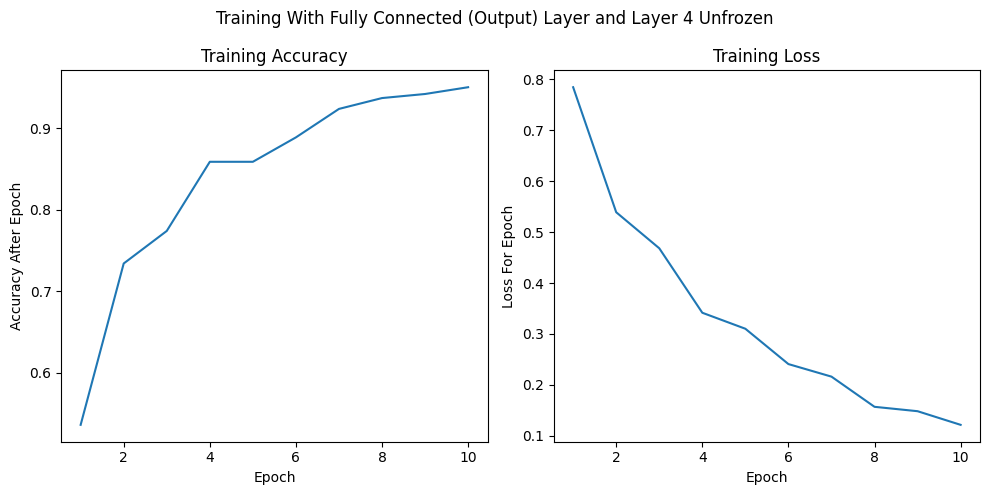

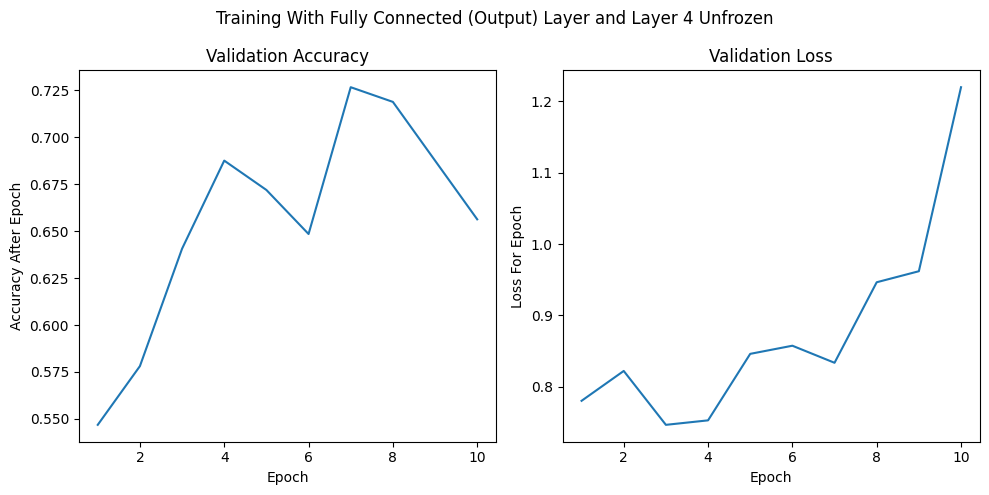

In [12]:
# This block fine-tunes layer 4 of the model

optimizer = optim.Adam(model.parameters(), lr=1e-4)

for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters(): # Unfreeze Layer 4 in this block
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

print("Training Model with Fully Connected (Output) Layer and Layer 4 Unfrozen:\n")

model, layer4_train_acc, layer4_train_losses, layer4_val_acc, layer4_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With Fully Connected (Output) Layer and Layer 4 Unfrozen"
plot_learning(num_epoch, layer4_train_acc, layer4_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer4_val_acc, layer4_val_losses, layer_description, dataset="val")

Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3 Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.12674243708982594
Training Accuracy After Epoch 1: 94.84%

Validation Loss For Epoch 1: 1.0885279218200594
Validation Accuracy After Epoch 1: 72.66%

Epoch 2/10:

Training Loss For Epoch 2: 0.08326422306747733
Training Accuracy After Epoch 2: 97.34%

Validation Loss For Epoch 2: 1.113700405228883
Validation Accuracy After Epoch 2: 73.44%

Epoch 3/10:

Training Loss For Epoch 3: 0.09051112843965631
Training Accuracy After Epoch 3: 96.34%

Validation Loss For Epoch 3: 1.0192047371529043
Validation Accuracy After Epoch 3: 73.44%

Epoch 4/10:

Training Loss For Epoch 4: 0.06843978649984654
Training Accuracy After Epoch 4: 97.34%

Validation Loss For Epoch 4: 0.9179840637370944
Validation Accuracy After Epoch 4: 72.66%

Epoch 5/10:

Training Loss For Epoch 5: 0.06806417413291439
Training Accuracy After Epoch 5: 98.00%

Validation Loss For Epoch 5: 0.9529473311267793
Vali

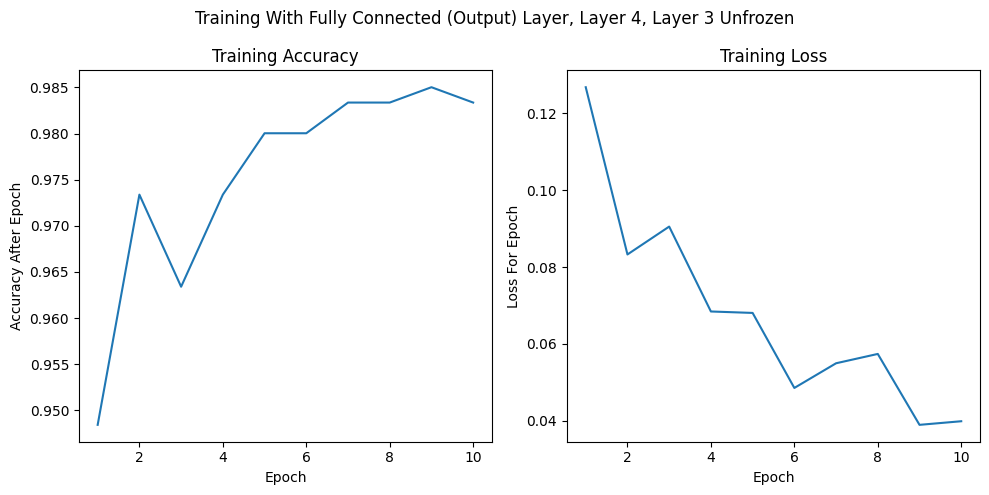

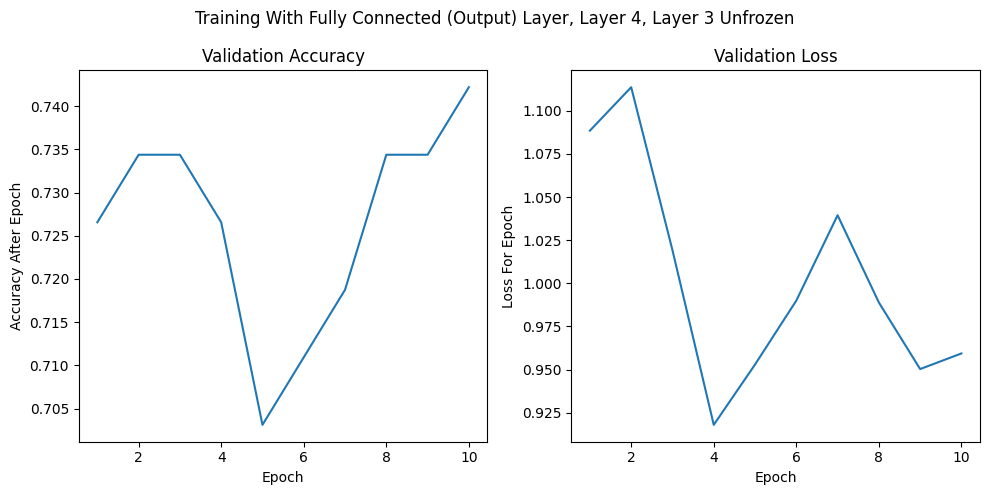

In [13]:
# This block fine-tunes layer 3 of the model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # Lower learning rate from 1e-4 to 1e-5 as learning plateaus

for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters(): # Unfreeze layer 3 in this block
    param.requires_grad = True
for param in model.layer4.parameters(): 
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

print("Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3 Unfrozen:\n")

model, layer3_train_acc, layer3_train_losses, layer3_val_acc, layer3_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With Fully Connected (Output) Layer, Layer 4, Layer 3 Unfrozen"
plot_learning(num_epoch, layer3_train_acc, layer3_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer3_val_acc, layer3_val_losses, layer_description, dataset="val")

Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2 Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.051966680765474296
Training Accuracy After Epoch 1: 97.50%

Validation Loss For Epoch 1: 1.0463745663873851
Validation Accuracy After Epoch 1: 71.88%

Epoch 2/10:

Training Loss For Epoch 2: 0.054882022375922754
Training Accuracy After Epoch 2: 98.50%

Validation Loss For Epoch 2: 1.0547672025859356
Validation Accuracy After Epoch 2: 70.31%

Epoch 3/10:

Training Loss For Epoch 3: 0.0832695260767154
Training Accuracy After Epoch 3: 96.34%

Validation Loss For Epoch 3: 1.1013246709480882
Validation Accuracy After Epoch 3: 71.88%

Epoch 4/10:

Training Loss For Epoch 4: 0.07939956846070505
Training Accuracy After Epoch 4: 96.34%

Validation Loss For Epoch 4: 0.9360337168909609
Validation Accuracy After Epoch 4: 73.44%

Epoch 5/10:

Training Loss For Epoch 5: 0.05912014129827304
Training Accuracy After Epoch 5: 97.67%

Validation Loss For Epoch 5: 0.9070797181

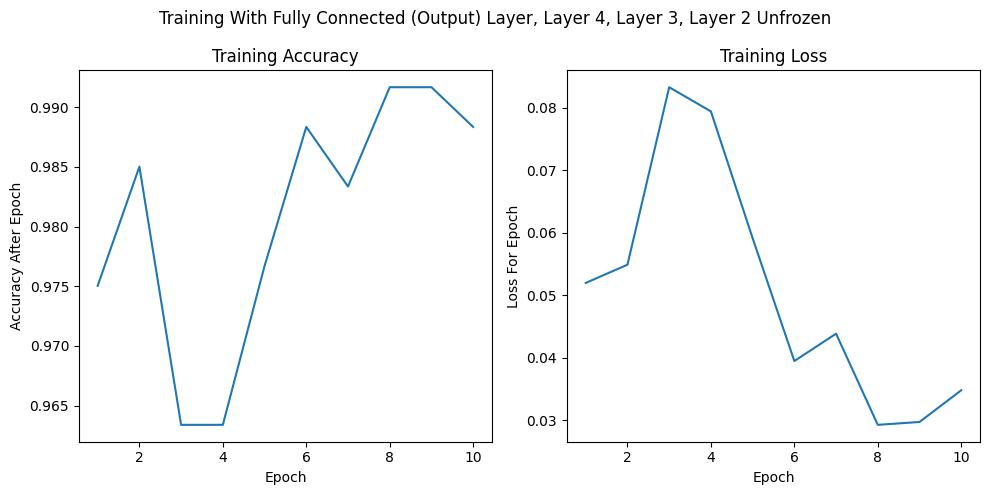

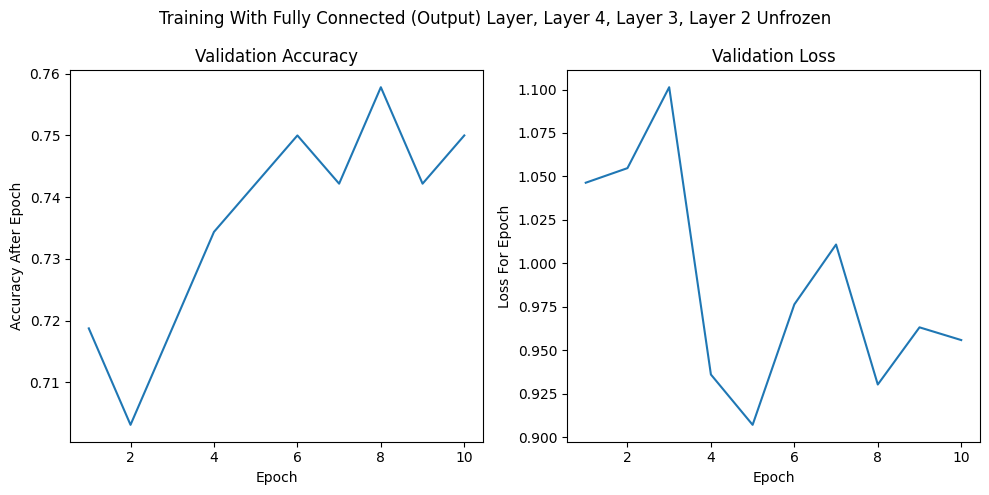

In [14]:
# This block fine-tunes layer 2 of the model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # Lower learning rate from 1e-4 to 1e-5 as learning plateaus

for param in model.parameters():
    param.requires_grad = False
for param in model.layer2.parameters(): # Unfreeze layer 2 in this block
    param.requires_grad = True
for param in model.layer3.parameters(): 
    param.requires_grad = True
for param in model.layer4.parameters(): 
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

print("Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2 Unfrozen:\n")

model, layer2_train_acc, layer2_train_losses, layer2_val_acc, layer2_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2 Unfrozen"
plot_learning(num_epoch, layer2_train_acc, layer2_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer2_val_acc, layer2_val_losses, layer_description, dataset="val")

Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2, Layer 1 Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.07236788900489276
Training Accuracy After Epoch 1: 98.17%

Validation Loss For Epoch 1: 1.0668519656173885
Validation Accuracy After Epoch 1: 76.56%

Epoch 2/10:

Training Loss For Epoch 2: 0.04855946591685677
Training Accuracy After Epoch 2: 98.34%

Validation Loss For Epoch 2: 1.0778971728868783
Validation Accuracy After Epoch 2: 75.00%

Epoch 3/10:

Training Loss For Epoch 3: 0.04817445599319051
Training Accuracy After Epoch 3: 98.17%

Validation Loss For Epoch 3: 1.047251122072339
Validation Accuracy After Epoch 3: 71.88%

Epoch 4/10:

Training Loss For Epoch 4: 0.06549275356783421
Training Accuracy After Epoch 4: 97.50%

Validation Loss For Epoch 4: 1.113750109449029
Validation Accuracy After Epoch 4: 67.97%

Epoch 5/10:

Training Loss For Epoch 5: 0.051322880875514496
Training Accuracy After Epoch 5: 98.17%

Validation Loss For Epoch 5: 1.213

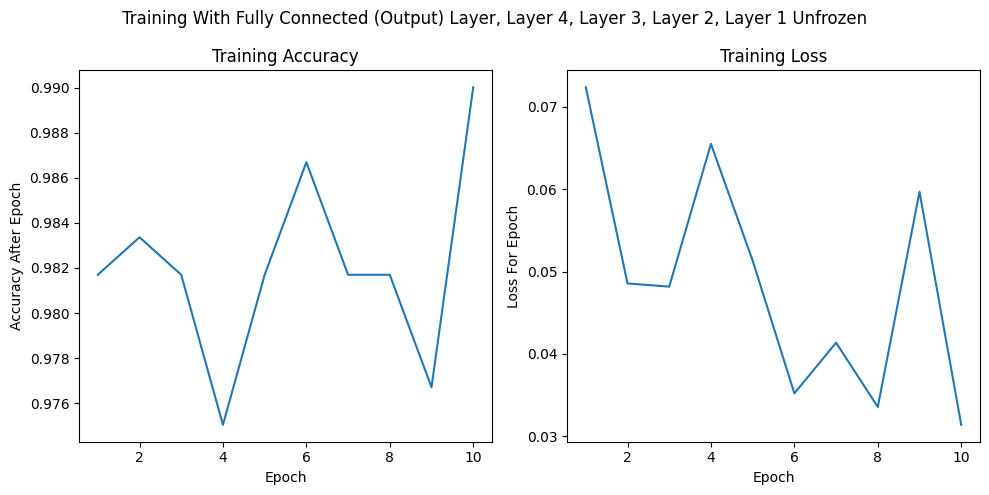

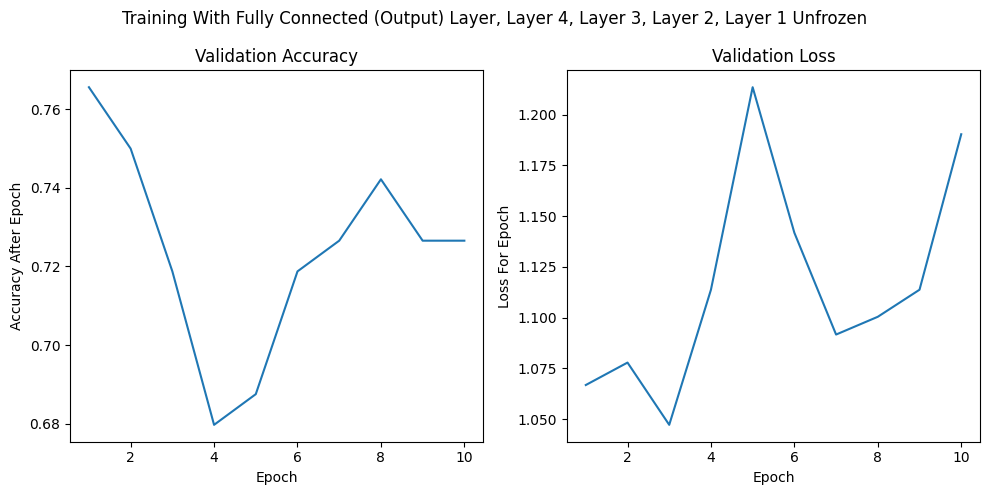

In [15]:
# This block fine-tunes layer 1 of the model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # Lower learning rate from 1e-4 to 1e-5 as learning plateaus

for param in model.parameters():
    param.requires_grad = False
for param in model.layer1.parameters(): # Unfreeze layer 1 in this block
    param.requires_grad = True
for param in model.layer2.parameters():
    param.requires_grad = True
for param in model.layer3.parameters(): 
    param.requires_grad = True
for param in model.layer4.parameters(): 
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

print("Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2, Layer 1 Unfrozen:\n")

model, layer1_train_acc, layer1_train_losses, layer1_val_acc, layer1_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2, Layer 1 Unfrozen"
plot_learning(num_epoch, layer1_train_acc, layer1_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer1_val_acc, layer1_val_losses, layer_description, dataset="val")

Training Model With All Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.02779627847117209
Training Accuracy After Epoch 1: 98.84%

Validation Loss For Epoch 1: 1.055894446792081
Validation Accuracy After Epoch 1: 76.56%

Epoch 2/10:

Training Loss For Epoch 2: 0.06807060161517924
Training Accuracy After Epoch 2: 97.67%

Validation Loss For Epoch 2: 1.0585236437618732
Validation Accuracy After Epoch 2: 76.56%

Epoch 3/10:

Training Loss For Epoch 3: 0.05191325438429699
Training Accuracy After Epoch 3: 98.17%

Validation Loss For Epoch 3: 1.046899882145226
Validation Accuracy After Epoch 3: 75.00%

Epoch 4/10:

Training Loss For Epoch 4: 0.03685481385107055
Training Accuracy After Epoch 4: 98.67%

Validation Loss For Epoch 4: 0.984636478126049
Validation Accuracy After Epoch 4: 75.00%

Epoch 5/10:

Training Loss For Epoch 5: 0.021873727760830904
Training Accuracy After Epoch 5: 99.17%

Validation Loss For Epoch 5: 1.0475900347810239
Validation Accuracy After Epoch 5: 71.09%



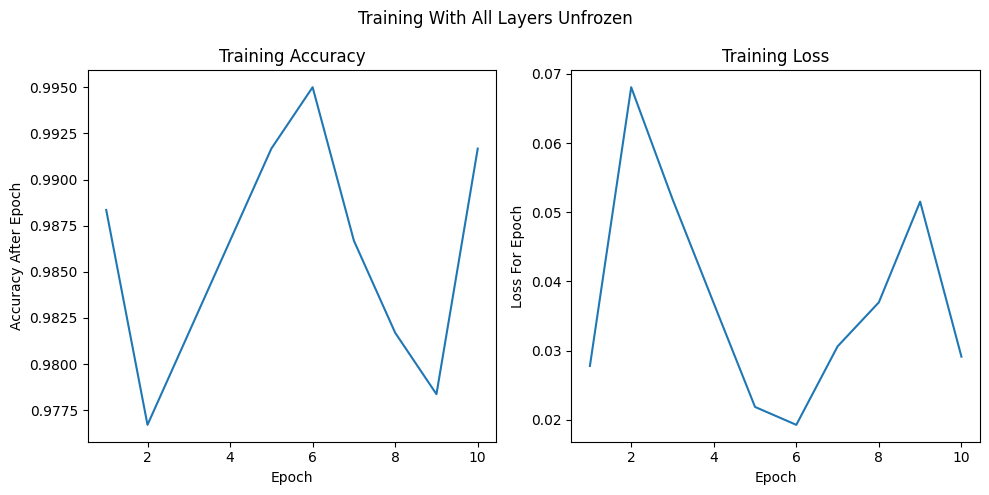

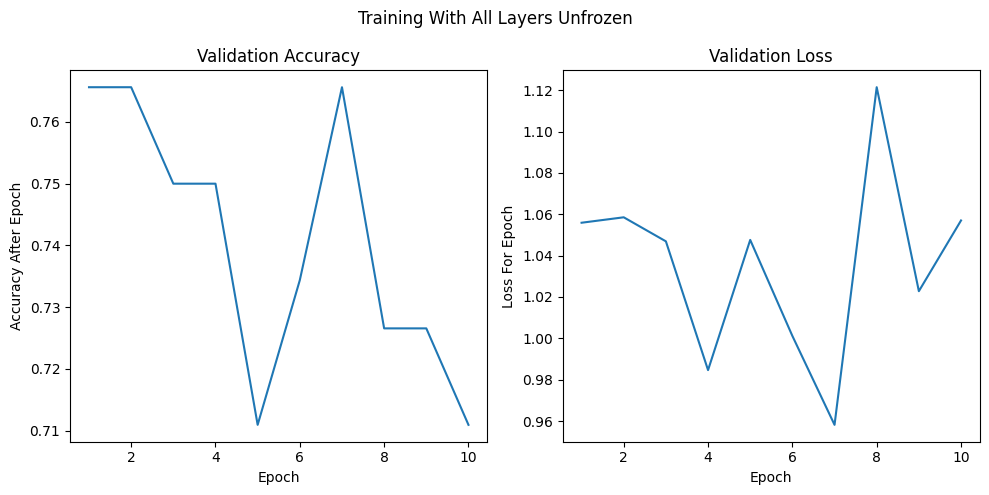

In [16]:
# This block fine-tunes convolutional layer (conv1) of the model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # Lower learning rate from 1e-4 to 1e-5 as learning plateaus

for param in model.parameters(): # Unfreeze all layers to capture all previously unfrozen layers and the final convolutional layer
    param.requires_grad = True

print("Training Model With All Layers Unfrozen:\n")

model, layer_train_acc, layer_train_losses, layer_val_acc, layer_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With All Layers Unfrozen"
plot_learning(num_epoch, layer_train_acc, layer_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer_val_acc, layer_val_losses, layer_description, dataset="val")

In [ ]:
# This block performs analysis and comparisons using the final newly trained model

model.eval()

output_list = []
correct = 0
total = 0
loss_trained = 0
with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        outputs = model(waveforms)
        _, predicted = torch.max(outputs, 1)
        total+= labels_num.size(0)
        correct+= (predicted == labels_num).sum().item()
        output_list.append(outputs)
        loss = criter(outputs,labels_num)
        loss_trained += loss.item() * waveforms.size(0)
        

print("{}% Test Accuracy With Newly Trained Model".format(correct/total*100))
print("Test Set Loss of {} With Newly Trained Model".format(loss_trained))



82.3076923076923% Test Accuracy With Newly Trained Model
Test Set Loss of 77.81880449154414 With Newly Trained Model


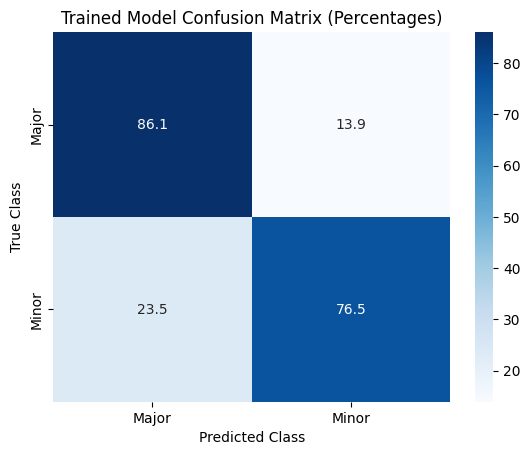

              precision    recall  f1-score   support

       Major       0.85      0.86      0.86        79
       Minor       0.78      0.76      0.77        51

    accuracy                           0.82       130
   macro avg       0.81      0.81      0.81       130
weighted avg       0.82      0.82      0.82       130



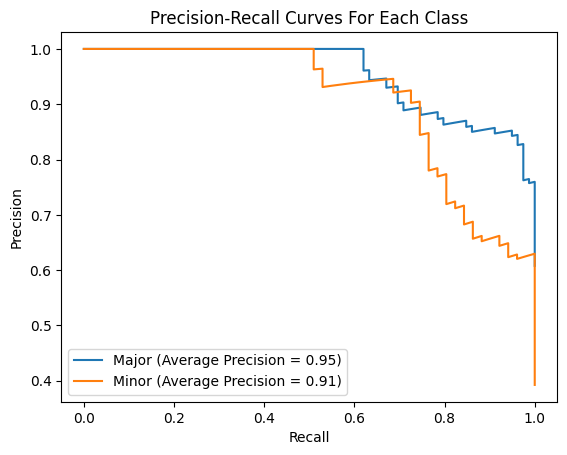

In [18]:
# This block generates the confusion matrix, classification report, and plots the PR curves for each class

from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score

model.eval()

class_names = ["Major", "Minor"]

label_prob = [] # list of all predicted classes probabilities
label_true = [] # list of true class labels
label_pred = [] # list of predicted class labels

with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        outputs = model(waveforms)
        probability = torch.softmax(outputs, dim = 1)
        _, pred = torch.max(outputs,1)
        #label_pred.extend(pred.cpu().numpy())
        #label_prob.extend(probability.cpu().numpy())
        #label_true.extend(labels.cpu().numpy())

        label_pred.extend(pred)
        label_prob.extend(probability)
        label_true.extend(labels_num)

label_prob = np.array(label_prob)
label_true = np.array(label_true)
label_pred = np.array(label_pred)

model_confusion = confusion_matrix(label_true, label_pred)
model_confusion_percent = model_confusion.astype('float') / model_confusion.sum(axis=1)[:, np.newaxis] * 100

plt.figure()
sns.heatmap(model_confusion_percent, cmap="Blues", annot=True, fmt = '.1f', xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Trained Model Confusion Matrix (Percentages)")
plt.show()

cr = classification_report(label_true, label_pred, target_names = class_names)
print(cr)

label_true_arr = np.eye(len(class_names))[label_true]

plt.figure()
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(label_true_arr[:,i], label_prob[:,i])
    average_precision = average_precision_score(label_true_arr[:,i], label_prob[:,i])

    
    plt.plot(recall, precision, label = "{} (Average Precision = {:.2f})".format(class_name, average_precision))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves For Each Class")
plt.legend()
plt.show()